<a href="https://colab.research.google.com/github/cacbondioxit/Vietnamese-Accent-Adding/blob/main/DatasetPreproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U evaluate sacrebleu accelerate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import DatasetDict, Dataset
from datasets import load_dataset, load_metric

import transformers
from transformers import TextDataset, DataCollatorForLanguageModeling
# from transformers import DataCollatorForSeq2Seq
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# from transformers import Trainer, TrainingArguments
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

import evaluate
import accelerate

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTORCH_USE_CUDA_DSA'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
checkpoint = "DezS/Accent-and-accentless-Vietnamese-dataset"
raw_dataset = load_dataset(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4036379 [00:00<?, ? examples/s]

In [4]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentlessSentences'],
        num_rows: 4036379
    })
})

Text(0, 0.5, 'Frequency')

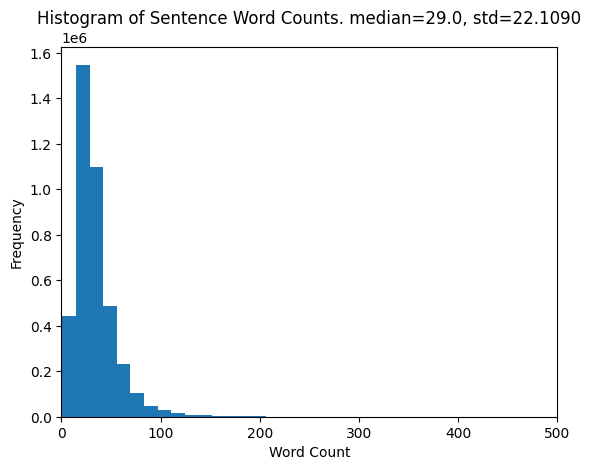

In [6]:
sentences_word_counts = [len(sentence.split()) for sentence in raw_dataset['train']['Sentences']]
plt.hist(sentences_word_counts, bins=100)
plt.title(f"Histogram of Sentence Word Counts. median={np.median(sentences_word_counts)}, std={np.std(sentences_word_counts):.4f}")
plt.xlim([0, 500])
plt.xlabel("Word Count")
plt.ylabel("Frequency")

In [7]:
# 남아있는 성조를 모두 제거

def remove_accents(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

In [8]:
# 성조 없애기 적용

updated_dataset = raw_dataset.map(lambda example: {"AccentRemovedSentences": remove_accents(example["AccentlessSentences"])},
                                  remove_columns=["AccentlessSentences"],
                                  num_proc=32,
                                  )

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/4036379 [00:00<?, ? examples/s]

In [9]:
updated_dataset = updated_dataset['train'].train_test_split(test_size=0.2, seed=42)
valid_test_dataset = updated_dataset['test'].train_test_split(test_size=0.5, seed=42)
splitted_dataset = DatasetDict({
    'train': updated_dataset['train'],
    'val': valid_test_dataset['train'],
    'test': valid_test_dataset['test'],
    })
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 3229103
    })
    val: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 403638
    })
    test: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 403638
    })
})

In [10]:
splitted_dataset['train'][0]

{'Sentences': 'Tình cờ chị nghe thấy bà nói chuyện điện thoại trong buồng: "Ừ, Thuý à, mẹ đây, sao năm nay không thấy gọi điện chúc Tết bố mẹ nữa thế?',
 'AccentRemovedSentences': 'Tinh co chi nghe thay ba noi chuyen dien thoai trong buong: "U, Thuy a, me day, sao nam nay khong thay goi dien chuc Tet bo me nua the?'}

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')

tokenizer_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/854k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/512k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

In [12]:
tokenizer.pad_token = tokenizer.eos_token

In [13]:
def tokenize_function(example):
    result = tokenizer(example["AccentRemovedSentences"], text_target=example["Sentences"],
                       truncation=True, padding='max_length', max_length=200, return_special_tokens_mask=True)
    # del result['special_tokens_mask']
    return result

In [14]:
transformers.logging.set_verbosity_error()

In [15]:
splitted_dataset['val'] = splitted_dataset['val'].map(tokenize_function,
                                                      remove_columns=["Sentences", "AccentRemovedSentences"],
                                                      num_proc=32) # multiprocessing

Map (num_proc=32):   0%|          | 0/403638 [00:00<?, ? examples/s]

In [16]:
splitted_dataset['val']

Dataset({
    features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
    num_rows: 403638
})

In [ ]:
splitted_dataset['val'][0]

In [17]:
splitted_dataset['test'] = splitted_dataset['test'].map(tokenize_function,
                                                        remove_columns=["Sentences", "AccentRemovedSentences"],
                                                        num_proc=32)

Map (num_proc=32):   0%|          | 0/403638 [00:00<?, ? examples/s]

In [ ]:
splitted_dataset['test'][0]

In [20]:
splitted_dataset['train'] = splitted_dataset['train'].map(tokenize_function,
                                                          remove_columns=["Sentences", "AccentRemovedSentences"],
                                                          num_proc=32)

Map (num_proc=32):   0%|          | 0/3229103 [00:00<?, ? examples/s]

In [ ]:
# splitted_dataset['train'][0]

In [21]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 3229103
    })
    val: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 403638
    })
    test: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 403638
    })
})

In [22]:
from huggingface_hub import notebook_login

notebook_login()

In [23]:
splitted_dataset.push_to_hub("cacbon-dioxit/Vietnamese-Accent-Removed-dataset", private=True)

Uploading the dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/170 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/135 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/135 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/135 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/135 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/135 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/135 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/cacbon-dioxit/Vietnamese-Accent-Removed-dataset/commit/adc39e1eedc1b540c674cd0ae6ccd99f2ed4e28e', commit_message='Upload dataset', commit_description='', oid='adc39e1eedc1b540c674cd0ae6ccd99f2ed4e28e', pr_url=None, pr_revision=None, pr_num=None)